<a href="https://colab.research.google.com/github/a-to-the-5/ReinforcementLearning/blob/master/Multi_armed_Bandits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hello :)

This notebook is a practical follow-along of chapter 2 of the "Reinforcement Learning: An Introduction" book by Sutton & Barto. It attempts to reproduce the techniques and experiments in python code, striving for simplicity and readability.

If you are exceited about reinforcement learning, then let us go!

# Multi-armed Bandits

The multi-armed bandit is a very simple form of the reinforcement learning problem. And although multi-armed bandits can seem too simple, they are already useful in introducing some of the main challenges and notions of the general reinforcement learning problem.

## The k-armed bandit problem
The definition of the k-armed bandit problem from the book is as follows:
> Consider the following learning problem. You are faced repeatedly with a choice among k different options, or actions. After each choice you receive a numerical reward chosen from a stationary probability distribution that depends on the action you selected. Your objective is to maximize the expected total reward over some time period, for example, over 1000 action selections, or time steps.

What does this mean? Let us imagine a game where you are given a choice of pressing one of two buttons. Pressing each button will give you a certain reward. However, this reward will not be the same every time you press the button. Let us say pressing button "A" will give you a reward sampled from normal ditribution of mean 5.1 and standard deviation 1, while button "B" gives you a reward sampled from normal distribution of mean 5.5 and standard deiation 1.

However, as the player, you do not know these distributions! Trying each button once will not tell you the full story, since you may be "lucky" the first time you press "A" and get a 5.4, and be unlucky when you press "B" and get a 5.2.

In the following sectinos we will see how an agent can learn to play that game!

## Action-value Methods

The simplest idea one can try is to try each action (button in the case of our example) many times, and calculate the mean and standard deviation of your tries. The more you try an action, the more your calculated mean and std will match those of the actual distribution of rewards of that action.

## The k-armed Testbed


In [ ]:
import io
import base64
import imageio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List, Type, Dict
from IPython.core.display import display, HTML

In [ ]:
class KArmedTestbed:
  def __init__(self, k: int, is_stationary: bool = True, cycle_length: int = 100, q_mean=0.0, **kwargs):
    self.k: int = k
    self.is_stationary = is_stationary
    self.cycle_length = cycle_length
    self.q_stars: np.ndarray = np.random.normal(loc=q_mean, size=k)
    if not self.is_stationary:
      self.previous_q_stars = np.array(self.q_stars)
      self.next_q_stars = np.random.normal(size=k)
    self.history: List[float] = []
    self.was_optimal_history: List[bool] = []
  
  def get_reward(self, action: int) -> float:
    reward: float = np.random.normal(loc=self.q_stars[action])
    self.history.append(reward)
    self.was_optimal_history.append(action == np.argmax(self.q_stars))
    if not self.is_stationary:
      self.update_q_stars()
    return reward
  
  def update_q_stars(self):
    change_after = 20.0
    step = len(self.history) % self.cycle_length
    if step == 0:
      self.previous_q_stars = self.next_q_stars
      self.next_q_stars = np.random.normal(size=self.k)
    self.q_stars = (self.cycle_length - step) / self.cycle_length * self.previous_q_stars + step / self.cycle_length * self.next_q_stars

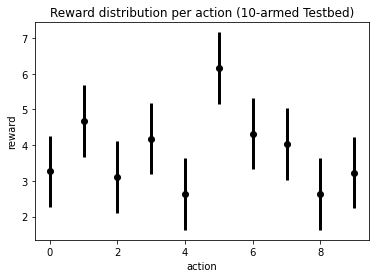

In [ ]:
testbed = KArmedTestbed(10, q_mean=4.0)
plt.errorbar(np.arange(10), testbed.q_stars, np.ones((10,)), fmt='ok', lw=3)
plt.xlabel('action')
plt.ylabel('reward')
plt.title('Reward distribution per action (10-armed Testbed)')
plt.show()

## Incremental implementation
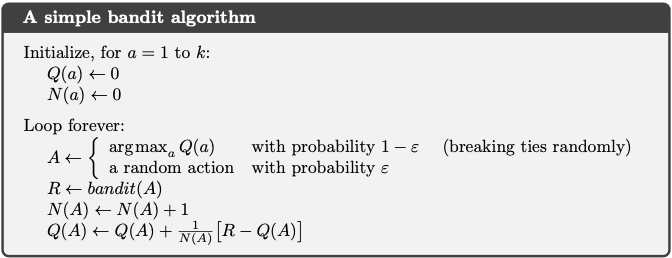

In [ ]:
class KArmedBandit:
  def __init__(self, k: int, env: KArmedTestbed, **kwargs):
    self.k: int = k
    self.env: KArmedTestbed = env
    self.qs: np.ndarray = np.ones((self.k,)) * kwargs.get('q1', 0.0)
    self.α: float =  kwargs.get('α', None)
    self.ns: np.ndarray = np.zeros((self.k,))
  
  def take_action(self) -> None:
    action: int = self.pick_action()
    reward: float = self.env.get_reward(action)
    self.update_bandit(action, reward)
  
  def update_bandit(self, action, reward):
    if self.ns[action] != 0.0:
      self.qs[action] += self.get_α(action) * (reward - self.qs[action])
    self.ns[action] += 1
  
  def get_α(self, action: int) -> float:
    if self.α is None:
      return 1/self.ns[action]
    else:
      return self.α
  
  def pick_action(self) -> int:
    raise Exception('Not implemented')

In [ ]:
class EpsilonGreedyKArmedBandit(KArmedBandit):
  def __init__(self, k: int, env: KArmedTestbed, **kwargs):
    super().__init__(k, env, **kwargs)
    self.ε: float = kwargs['ε']
  
  def pick_action(self) -> int:
    if np.random.uniform() < self.ε:
      return np.random.randint(0, self.k)
    else:
      return np.argmax(self.qs)
  
  def get_confidence_bounds(self) -> np.ndarray:
    return np.zeros((self.k,))
  
  @staticmethod
  def descriptor(**kwargs) -> str:
    if kwargs['ε'] == 0.0:
      attribs = ['%s=%s' % (k, v) for k, v in kwargs.items() if k != 'ε']
      suffix = (' - (%s)' % ', '.join(attribs)) if len(attribs) else ''
      return 'greedy%s' % suffix
    else:
      attribs = ['%s=%s' % (k, v) for k, v in kwargs.items()]
      suffix = (' - (%s)' % ', '.join(attribs)) if len(attribs) else ''
      return 'ε-greedy%s' % suffix

In [ ]:
class Experiment:
  def __init__(self, agent_class: Type[KArmedBandit], k: int, num_episodes: int, **kwargs):
    self.k: int = k
    self.num_episodes: int = num_episodes
    self.agent_class: Type[KArmedBandit] = agent_class
    self.kwargs: Dict = kwargs
    self.sum_rewards: np.ndarray = np.zeros((num_episodes,))
    self.sum_was_optimal: np.ndarray = np.zeros((num_episodes,))
    self.runs: int = 0
    self.last_agent: KArmedBandit = None
    self.last_testbed: KArmedTestbed = None
  
  def run(self, num_times) -> None:
    print("Running '%s' experiment, %i times:" % 
          (self.agent_class.descriptor(**self.kwargs), num_times), flush=True)
    for i in tqdm(range(num_times)):
      testbed = KArmedTestbed(self.k, **self.kwargs)
      agent: KArmedBandit = self.agent_class(self.k, testbed, **self.kwargs)
      for i in range(self.num_episodes):
        agent.take_action()
      self.sum_rewards += np.array(testbed.history)
      self.sum_was_optimal += np.array(testbed.was_optimal_history)
      self.runs += 1
      self.last_agent = agent
      self.last_testbed = testbed
  
  def plot_result(self, color) -> None:
    average = self.sum_rewards / self.runs
    plt.plot(average, c=color, label=self.agent_class.descriptor(**self.kwargs))
    plt.legend()
  
  def plot_optimal_percentage(self, color) -> None:
    average = self.sum_was_optimal / self.runs
    plt.plot(average * 100, c=color, label=self.agent_class.descriptor(**self.kwargs))
    plt.legend()
  
  def plot_estimation(self, color) -> None:
    plt.errorbar(np.arange(self.k), self.last_testbed.q_stars, np.ones((self.k,)), fmt='ok', lw=3, label='Q* distribution')
    plt.errorbar(np.arange(self.k) + 0.3, self.last_agent.qs, self.last_agent.get_confidence_bounds(), 
                 fmt='o', c=color, lw=3, label='Q + confidence bounds')
    plt.legend()
    plt.title('Actual Q* distribution and agent\'s estimation per action\n%s'% self.agent_class.descriptor(**self.kwargs))
    plt.xlabel('action')
    plt.ylabel('reward')
    plt.show()

In [ ]:
num_experiments = 2000
num_episodes = 1000
k = 10
experiments = [
    Experiment(EpsilonGreedyKArmedBandit, k, num_episodes, ε=0.0),
    Experiment(EpsilonGreedyKArmedBandit, k, num_episodes, ε=0.01),
    Experiment(EpsilonGreedyKArmedBandit, k, num_episodes, ε=0.1),
]
for exp in experiments:
  exp.run(num_experiments)

Running 'greedy' experiment, 2000 times:


100%|██████████| 2000/2000 [00:46<00:00, 42.87it/s]

Running 'ε-greedy - (ε=0.01)' experiment, 2000 times:



100%|██████████| 2000/2000 [00:43<00:00, 45.59it/s]

Running 'ε-greedy - (ε=0.1)' experiment, 2000 times:



100%|██████████| 2000/2000 [00:46<00:00, 43.13it/s]


Text(0, 0.5, 'average reward')

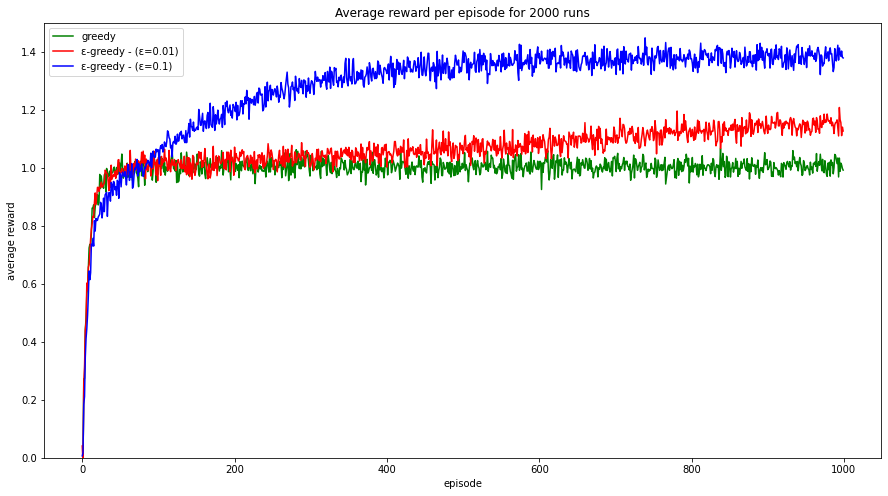

In [ ]:
plt.figure(figsize=(15, 8))
colors = ['g', 'r', 'b']
for exp, color in zip(experiments, colors):
  exp.plot_result(color)
plt.title('Average reward per episode for %i runs' % num_experiments)
plt.ylim(0, 1.5)
plt.xlabel('episode')
plt.ylabel('average reward')

Text(0, 0.5, '% optimal action')

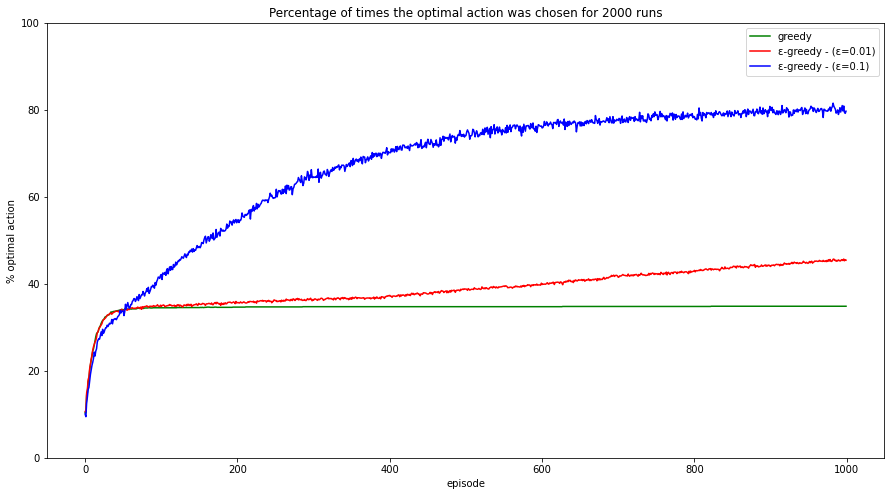

In [ ]:
plt.figure(figsize=(15, 8))
for exp, color in zip(experiments, colors):
  exp.plot_optimal_percentage(color)
plt.title('Percentage of times the optimal action was chosen for %i runs' % num_experiments)
plt.ylim(0, 100)
plt.xlabel('episode')
plt.ylabel('% optimal action')

## Tracking a Nonstationary Problem

In [ ]:
class AnimatedGIFBuilder:
  def __init__(self):
    self.array = []
  
  def add_frame(self, frame):
    self.array.append(frame)
  
  def get_buffer(self):
    buffer = io.BytesIO()
    with imageio.get_writer(buffer, mode='I', format='gif') as writer:
      for im in self.array:
        writer.append_data(im)
    return buffer
  
  def save_to_file(self, file_name):
    with open(file_name, "wb") as outfile:
      outfile.write(self.get_buffer().getbuffer())
  
  def display_image(self):
    file_name = '/tmp/AnimatedGIFBuilder_tmp_image.gif'
    self.save_to_file(file_name)
    with open(file_name, "rb") as image_file:
      encoded_string = base64.b64encode(image_file.read())
      display(HTML("<img src='data:image/gif;base64,%s'/>" % encoded_string.decode()))

In [ ]:
def fig_to_numpy(fig):
  fig.canvas.draw()
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
  data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  plt.close()
  return data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  This is separate from the ipykernel package so we can avoid doing imports until



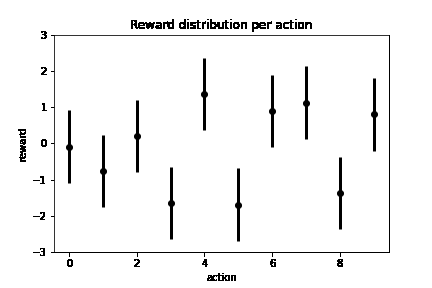

In [ ]:
testbed = KArmedTestbed(10, is_stationary=False, cycle_length=20)
gif_builder = AnimatedGIFBuilder()
for i in range(200):
  fig = plt.figure()
  plt.errorbar(np.arange(10), testbed.q_stars, np.ones((10,)), fmt='ok', lw=3)
  plt.xlabel('action')
  plt.ylabel('reward')
  plt.ylim(-3, 3)
  plt.title('Reward distribution per action')
  gif_builder.add_frame(fig_to_numpy(fig))
  testbed.get_reward(0)
gif_builder.display_image()

In [ ]:
num_experiments = 2000
num_episodes = 1000
k = 10
experiments = [
    Experiment(EpsilonGreedyKArmedBandit, k, num_episodes, α=None, ε=0.1, is_stationary=False, cycle_length=100),
    Experiment(EpsilonGreedyKArmedBandit, k, num_episodes, α=0.1,  ε=0.1, is_stationary=False, cycle_length=100)
]
for exp in experiments:
  exp.run(num_experiments)

Running 'ε-greedy - (α=None, ε=0.1, is_stationary=False, cycle_length=100)' experiment, 2000 times:


100%|██████████| 2000/2000 [00:59<00:00, 33.50it/s]

Running 'ε-greedy - (α=0.1, ε=0.1, is_stationary=False, cycle_length=100)' experiment, 2000 times:



100%|██████████| 2000/2000 [00:57<00:00, 34.53it/s]


Text(0, 0.5, 'average reward')

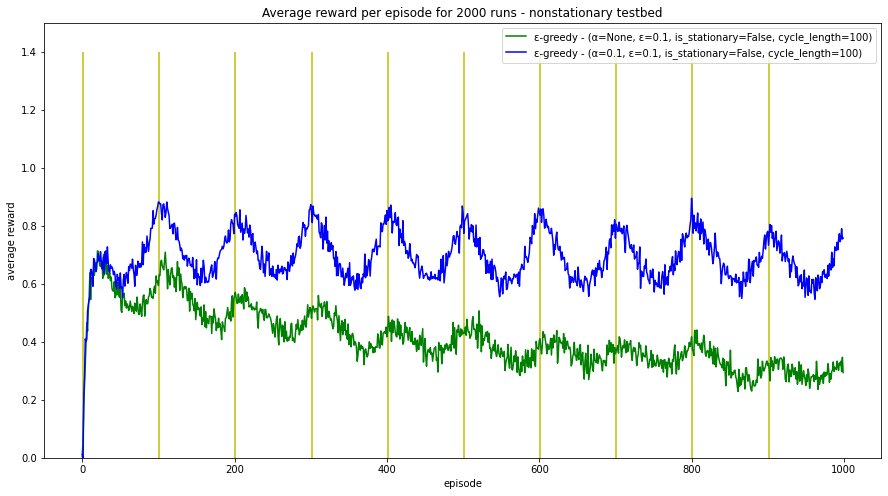

In [ ]:
plt.figure(figsize=(15, 8))
colors = ['g', 'b']
for exp, color in zip(experiments, colors):
  exp.plot_result(color)
plt.title('Average reward per episode for %i runs - nonstationary testbed' % num_experiments)
plt.ylim(0, 1.5)
plt.vlines(range(1, 1001, 100), 0, 1.4, colors='y')
plt.xlabel('episode')
plt.ylabel('average reward')

## Optimistic Initial Value

In [ ]:
num_experiments = 2000
num_episodes = 1000
k = 10
experiments = [
    Experiment(EpsilonGreedyKArmedBandit, k, num_episodes, q1=5.0, α=0.1, ε=0.0),
    Experiment(EpsilonGreedyKArmedBandit, k, num_episodes, q1=0.0, α=0.1, ε=0.1)
]
for exp in experiments:
  exp.run(num_experiments)

Running 'greedy - (q1=5.0, α=0.1)' experiment, 2000 times:


100%|██████████| 2000/2000 [00:44<00:00, 44.50it/s]

Running 'ε-greedy - (q1=0.0, α=0.1, ε=0.1)' experiment, 2000 times:



100%|██████████| 2000/2000 [00:47<00:00, 42.39it/s]


Text(0, 0.5, '% optimal action')

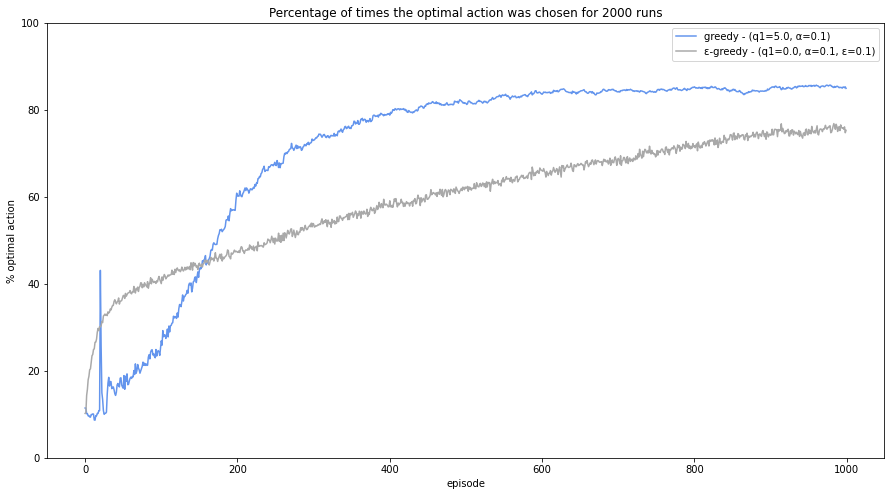

In [ ]:
plt.figure(figsize=(15, 8))
colors = ['cornflowerblue', 'darkgrey']
for exp, color in zip(experiments, colors):
  exp.plot_optimal_percentage(color)
plt.title('Percentage of times the optimal action was chosen for %i runs' % num_experiments)
plt.ylim(0, 100)
plt.xlabel('episode')
plt.ylabel('% optimal action')

## Upper-Confidence-Bound Action Selection

In [ ]:
class UCBKArmedBandit(KArmedBandit):
  def __init__(self, k, env, **kwargs):
    super().__init__(k, env, **kwargs)
    self.c = kwargs['c']
  
  def pick_action(self):
    return np.argmax(self.qs + self.get_confidence_bounds())
  
  def get_confidence_bounds(self):
    return self.c * np.sqrt(np.log(np.sum(self.ns)) / self.ns)
  
  @staticmethod
  def descriptor(**kwargs):
    attribs = ['%s=%s' % (k, v) for k, v in kwargs.items()]
    suffix = (' - (%s)' % ', '.join(attribs)) if len(attribs) else ''
    return 'UCB%s' % suffix

In [ ]:
num_experiments = 2000
num_episodes = 1000
k = 10
experiments = [
    Experiment(UCBKArmedBandit, k, num_episodes, c=2),
    Experiment(EpsilonGreedyKArmedBandit, k, num_episodes, ε=0.1),
]
for exp in experiments:
  exp.run(num_experiments)

Running 'UCB - (c=2)' experiment, 2000 times:


  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 2000/2000 [01:18<00:00, 25.61it/s]

Running 'ε-greedy - (ε=0.1)' experiment, 2000 times:



100%|██████████| 2000/2000 [00:47<00:00, 42.11it/s]


Text(0, 0.5, 'average reward')

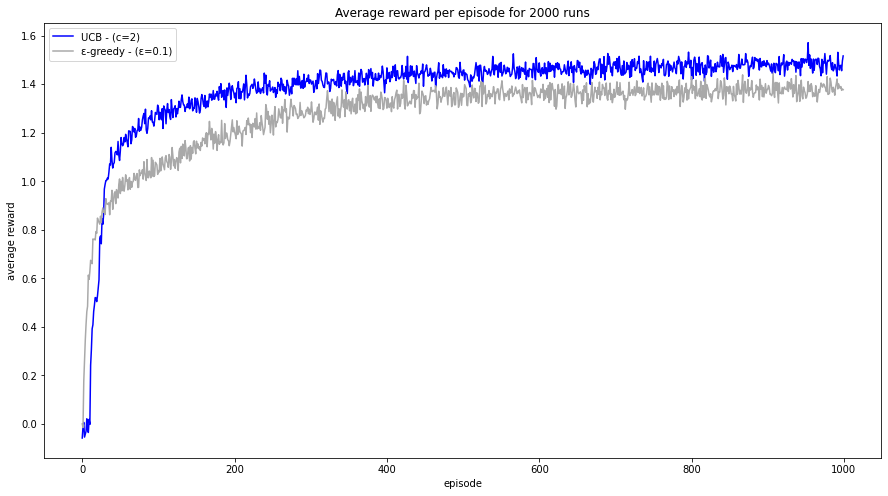

In [ ]:
plt.figure(figsize=(15, 8))
colors = ['blue', 'darkgrey']
for exp, color in zip(experiments, colors):
  exp.plot_result(color)
plt.title('Average reward per episode for %i runs' % num_experiments)
plt.xlabel('episode')
plt.ylabel('average reward')

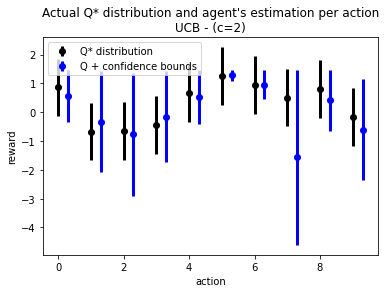

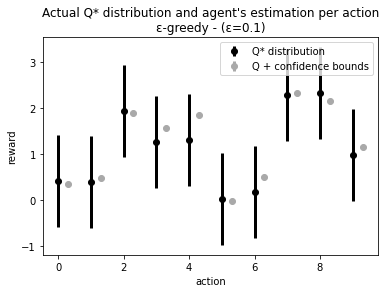

In [ ]:
for exp, color in zip(experiments, colors):
  exp.plot_estimation(color)

## Gradent Bandit Algorithm

In [ ]:
class GradientBandit(KArmedBandit):
  def __init__(self, k, env, **kwargs):
    super().__init__(k, env, **kwargs)
    self.with_baseline = kwargs.get('with_baseline', True)
    self.α: float =  kwargs.get('α', None)
    self.h = np.zeros((k,))
    self.π = np.ones((k,))/self.k
    self.n = 0
    self.r_mean = 0.0
  
  def pick_action(self):
    return np.random.choice(self.k, p=self.π)
  
  def update_bandit(self, action, reward):
    is_action = np.array(range(self.k)) == action
    self.h += is_action * (self.α * (reward - self.r_mean) * (1 - self.π))
    self.h -= np.logical_not(is_action) * (self.α * (reward - self.r_mean) * (self.π))
    if self.with_baseline:
      self.r_mean += 1/max(self.n, 1) * (reward - self.r_mean)
    self.n += 1
    self.π = self.get_π()

  def get_π(self):
    exp = np.exp(self.h)
    return exp/exp.sum()
  
  def get_α(self, action: int) -> float:
    if self.α is None:
      return 1/self.ns[action]
    else:
      return self.α
  
  def get_confidence_bounds(self):
    return np.zeros((k,))
  
  @staticmethod
  def descriptor(**kwargs):
    attribs = ['%s=%s' % (k, v) for k, v in kwargs.items()]
    suffix = (' - (%s)' % ', '.join(attribs)) if len(attribs) else ''
    return 'gradient bandit%s' % suffix

In [ ]:
num_experiments = 2000
num_episodes = 1000
k = 10
experiments = [
    Experiment(GradientBandit, k, num_episodes, q_mean=4.0, with_baseline=True, α=0.1),
    Experiment(GradientBandit, k, num_episodes, q_mean=4.0, with_baseline=True, α=0.4),
    Experiment(GradientBandit, k, num_episodes, q_mean=4.0, with_baseline=False, α=0.1),
    Experiment(GradientBandit, k, num_episodes, q_mean=4.0, with_baseline=False, α=0.4),
]
for exp in experiments:
  exp.run(num_experiments)

Running 'gradient bandit - (q_mean=4.0, with_baseline=True, α=0.1)' experiment, 2000 times:


100%|██████████| 2000/2000 [03:30<00:00,  9.50it/s]

Running 'gradient bandit - (q_mean=4.0, with_baseline=True, α=0.4)' experiment, 2000 times:



100%|██████████| 2000/2000 [03:34<00:00,  9.34it/s]

Running 'gradient bandit - (q_mean=4.0, with_baseline=False, α=0.1)' experiment, 2000 times:



100%|██████████| 2000/2000 [03:17<00:00, 10.12it/s]

Running 'gradient bandit - (q_mean=4.0, with_baseline=False, α=0.4)' experiment, 2000 times:



100%|██████████| 2000/2000 [03:32<00:00,  9.39it/s]


Text(0, 0.5, '% optimal action')

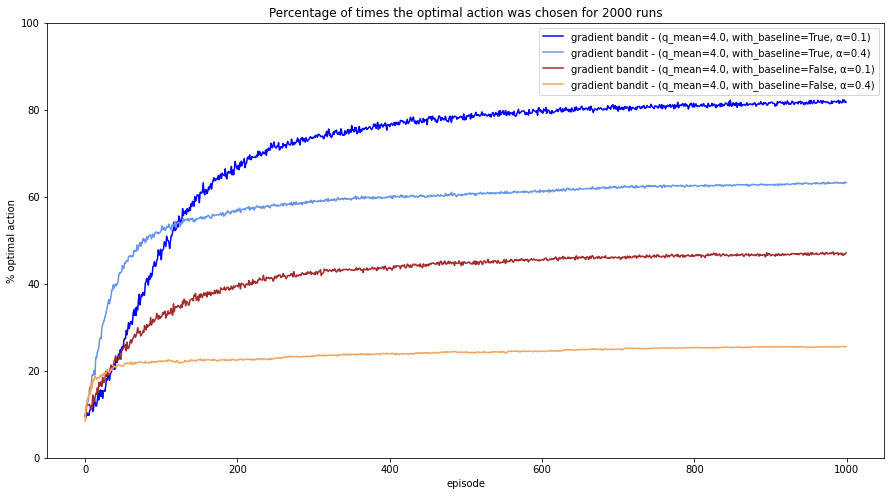

In [ ]:
plt.figure(figsize=(15, 8))
colors = ['blue', 'cornflowerblue', 'brown', 'sandybrown']
for exp, color in zip(experiments, colors):
  exp.plot_optimal_percentage(color)
plt.title('Percentage of times the optimal action was chosen for %i runs' % num_experiments)
plt.ylim(0, 100)
plt.xlabel('episode')
plt.ylabel('% optimal action')